In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import math
import cv2
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape([60000,28,28,1])
test_images = test_images.reshape([10000,28,28, 1])

In [2]:
IMG_SIZE = 32
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255)
    ])

train_images = np.array([resize_and_rescale(img) for img in train_images])
test_images = np.array([resize_and_rescale(img) for img in test_images])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), activation='relu', padding='same'))
            model.add(layers.BatchNormalization())
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    activation='relu', padding='same'))
            model.add(layers.BatchNormalization())
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=5, batch_size = 256, shuffle=True, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
235/235 [==============================] - 35s 112ms/step - loss: 0.8117 - accuracy: 0.8342 - val_loss: 11.3778 - val_accuracy: 0.1135
Epoch 2/5
235/235 [==============================] - 24s 102ms/step - loss: 0.0619 - accuracy: 0.9842 - val_loss: 0.4561 - val_accuracy: 0.8774
Epoch 3/5
235/235 [==============================] - 24s 102ms/step - loss: 0.0469 - accuracy: 0.9878 - val_loss: 0.0936 - val_accuracy: 0.9801
Epoch 4/5
235/235 [==============================] - 24s 102ms/step - loss: 0.0395 - accuracy: 0.9900 - val_loss: 0.0545 - val_accuracy: 0.9861
Epoch 5/5
235/235 [==============================] - 24s 102ms/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.0550 - val_accuracy: 0.9867


Text(0.5, 1.0, 'accuracy vs epoch')

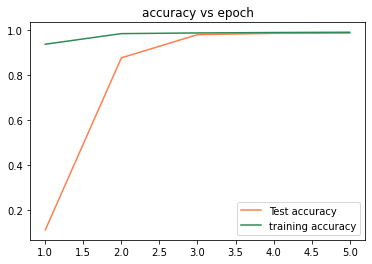

In [5]:
x_ax = [1,2,3,4,5]
plt.plot(x_ax, history.history['val_accuracy'], label='Test accuracy', color="coral")
plt.plot(x_ax, history.history['accuracy'], label='training accuracy', color="seagreen")
plt.legend()
plt.title('accuracy vs epoch')

Text(0.5, 1.0, 'loss vs epoch')

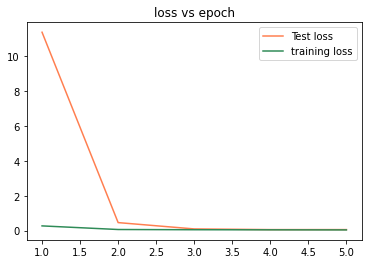

In [6]:
plt.plot(x_ax, history.history['val_loss'], label='Test loss', color="coral")
plt.plot(x_ax, history.history['loss'], label='training loss', color="seagreen")
plt.legend()
plt.title('loss vs epoch')

In [7]:
np.flip(train_images, 1).shape

(60000, 32, 32, 1)

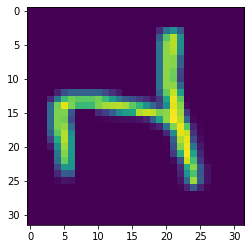

In [8]:
# flip from top to bottom
plt.imshow(tf.experimental.numpy.flip(train_images, 1)[2])

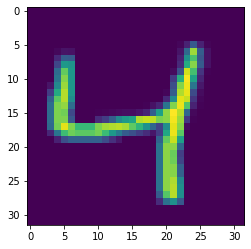

In [9]:
plt.imshow(train_images[2])

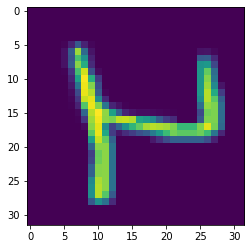

In [10]:
# flip from left to right
plt.imshow(tf.experimental.numpy.flip(train_images, 2)[2])

In [11]:
y_pred = model.predict(test_images)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9866

In [12]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.4342

In [13]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.3714

In [14]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=sigma)
    y_pred = model.predict(test_images+noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.986
0.9881
0.1942


In [15]:
train_images_aug = np.concatenate([train_images, np.flip(train_images, 1), np.flip(train_images, 2)])
train_labels_aug = np.concatenate([train_labels, train_labels, train_labels])

In [16]:
lst_sigma = [0.01, 0.1, 1]
train_set_shape = train_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=train_set_shape, stddev=sigma)
    train_images_aug = np.concatenate([train_images_aug, train_images+noise])
    train_labels_aug = np.concatenate([train_labels_aug, train_labels])

In [17]:
train_images_aug.shape

(360000, 32, 32, 1)

In [18]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), activation='relu', padding='same'))
            model.add(layers.BatchNormalization())
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    activation='relu', padding='same'))
            model.add(layers.BatchNormalization())
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images_aug, train_labels_aug, epochs=5, batch_size = 256, shuffle=True, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
1407/1407 [==============================] - 145s 101ms/step - loss: 0.8058 - accuracy: 0.7629 - val_loss: 0.0674 - val_accuracy: 0.9789
Epoch 2/5
1407/1407 [==============================] - 139s 99ms/step - loss: 0.1357 - accuracy: 0.9607 - val_loss: 0.0391 - val_accuracy: 0.9889
Epoch 3/5
1407/1407 [==============================] - 137s 98ms/step - loss: 0.1392 - accuracy: 0.9608 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 4/5
1407/1407 [==============================] - 137s 97ms/step - loss: 0.1235 - accuracy: 0.9635 - val_loss: 0.0444 - val_accuracy: 0.9860
Epoch 5/5
1407/1407 [==============================] - 137s 97ms/step - loss: 0.0885 - accuracy: 0.9731 - val_loss: 0.0488 - val_accuracy: 0.9866


In [20]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9803

In [21]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9816

In [22]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=sigma)
    y_pred = model.predict(test_images+noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.988
0.9913
0.8746


In [23]:
y_pred = model.predict(test_images)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9865